In [1]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
%matplotlib notebook
import matplotlib.pyplot as plt
import cProfile

In [2]:
init_state = np.zeros(4)

In [3]:
def euler(func, init, t, args):
    r = np.zeros((len(t), len(init)))
    r[0] = init
    for i in range(1, len(t)):
        r[i] = r[i-1] + (t[i]-t[i-1]) * func(t[i-1], r[i-1], *args)
    return r

In [4]:
def derivatives(t, state, forces, mass):
    if len(forces):
        acc = np.sum([force(state, t) for force in forces], axis=0)/mass
    else:
        acc = [0,0]
#     print(state)
    return np.array([state[2], state[3], acc[0], acc[1]])

In [5]:
def const_force_factory(force):
    def constant_force(state, t):
        return force
    return constant_force

In [6]:
def drag_factory(coeff):
    def drag(state, t):
        return -coeff*state[2:]
    return drag

In [7]:
def central_factory(coeff):
    def central(state, t):
        return -coeff*state[:2]
    return central

In [8]:
def linear_force_factory(coeff):
    def central(state, t):
        return -coeff*state[:2]/np.sqrt((state[0]**2 + state[1]**2))
    return central

In [9]:
derivatives(0, init_state, [const_force_factory([1,.5]), const_force_factory([2,-3])], 2)

array([ 0.  ,  0.  ,  1.5 , -1.25])

# Basic tests

In [110]:
forces = [const_force_factory([0,-9.81])]
res = odeint(derivatives, [0,0,1,5], np.linspace(0,1,100), args=(forces, 1), tfirst=True)
res2 = euler(derivatives, [0,0,1,5], np.linspace(0,1,100), args=(forces, 1))

<IPython.core.display.Javascript object>


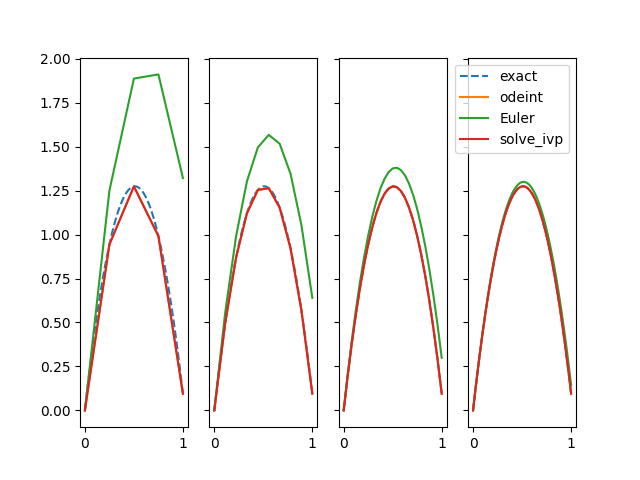

In [138]:
fig, ax = plt.subplots(1,4, sharex=True, sharey=True)
ax = ax.flatten()
n = [5,10,25,100]
for i, axis in enumerate(ax):
    res = odeint(derivatives, [0,0,1,5], np.linspace(0,1,n[i]), args=(forces, 1), tfirst=True)
    res2 = euler(derivatives, [0,0,1,5], np.linspace(0,1,n[i]), args=(forces, 1))
    res3 = solve_ivp(derivatives, (0,1), [0,0,1,5], args=(forces, 1), t_eval=np.linspace(0,1,n[i]))
    tspace = np.linspace(0,1,100)
    axis.plot(1*tspace, 5*tspace-9.81*tspace**2/2, "--", label="exact")
    axis.plot(res[:,0], res[:,1], label="odeint")
    axis.plot(res2[:,0], res2[:,1], label="Euler")
    axis.plot(res3.y.T[:,0], res3.y.T[:,1], label="solve_ivp")
#     axis.axis("equal")
ax[-1].legend()

In [194]:
print("odeint:    ", end="")
%timeit res = odeint(derivatives, [0,0,1,5], np.linspace(0,1,100), args=(forces, 1), tfirst=True)
print("euler:     ", end="")
%timeit res2 = euler(derivatives, [0,0,1,5], np.linspace(0,1,100), args=(forces, 1))
print("solve_ivp: ", end="")
%timeit res3 = solve_ivp(derivatives, (0,1), [0,0,1,5], args=(forces, 1), t_eval=np.linspace(0,1,100))

odeint:    279 µs ± 4.37 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
euler:     2.02 ms ± 120 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
solve_ivp: 1.62 ms ± 5.85 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [195]:
print("odeint:    ", end="")
%timeit res = odeint(derivatives, [0,0,1,5], np.linspace(0,1,5), args=(forces, 1), tfirst=True)
print("euler:     ", end="")
%timeit res2 = euler(derivatives, [0,0,1,5], np.linspace(0,1,5), args=(forces, 1))
print("solve_ivp: ", end="")
%timeit res3 = solve_ivp(derivatives, (0,1), [0,0,1,5], args=(forces, 1), t_eval=np.linspace(0,1,5))

odeint:    245 µs ± 1.04 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
euler:     118 µs ± 3.24 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
solve_ivp: 1.52 ms ± 3.04 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
def test(init, times, forces):
    fig, ax = plt.subplots(1,4, sharex=True, sharey=True)
    ax = ax.flatten()
    n = [5,10,25,100]
    for i, axis in enumerate(ax):
        res = odeint(derivatives, init, times[i], args=(forces, 1), tfirst=True)
        res2 = euler(derivatives, init, times[i], args=(forces, 1))
        res3 = solve_ivp(derivatives, (times[i][0], times[i][-1]), init, args=(forces, 1), t_eval=times[i])
        axis.plot(res[:,0], res[:,1], "x--", label="odeint")
        axis.plot(res2[:,0], res2[:,1], "x--", label="Euler")
        axis.plot(res3.y.T[:,0], res3.y.T[:,1], "x--", label="solve_ivp")
    ax[-1].legend()
    return (ax, res, res2, res3)

<IPython.core.display.Javascript object>


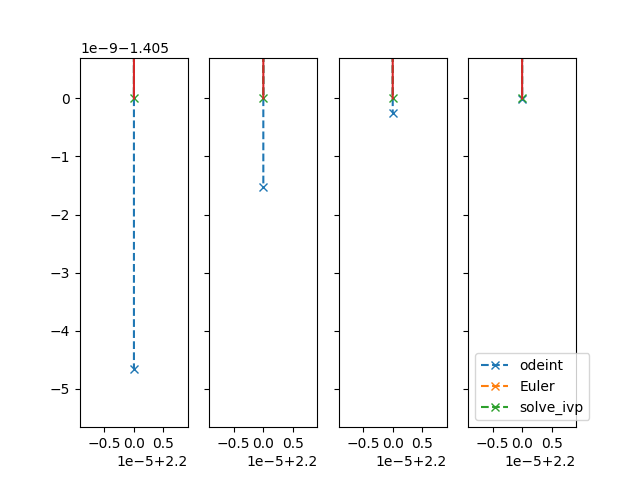

In [183]:
ax, res, res2, res3 = test([1,2,1.2,1.5], [np.linspace(0,1,n) for n in (5,10,25,100)], [const_force_factory([0,-9.81])])
tspace = np.linspace(0,1,100)
for axis in ax:
    axis.plot(1+1.2*tspace, 2+1.5*tspace-9.81*tspace**2/2, "-", label="exact")

# Linear acceleration

<IPython.core.display.Javascript object>


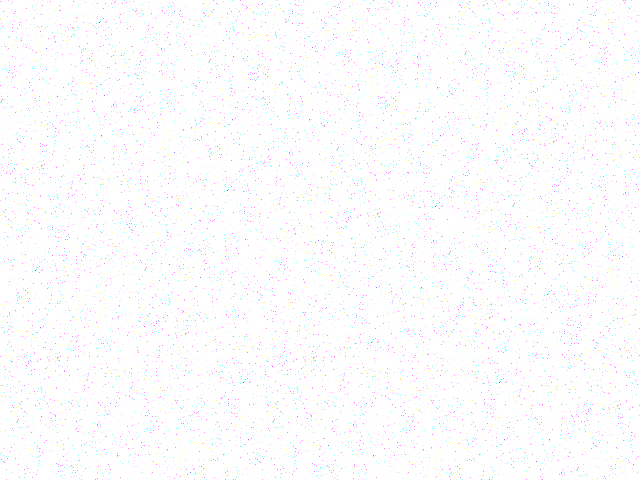

In [245]:
ax, res, res2, res3 = test([1,2,1.2,1.5], [np.linspace(0,1,n) for n in (5,10, 10, 10)], [const_force_factory([1.5,2.3])])
tspace = np.linspace(0,1,100)
for axis in ax:
    axis.plot(1+1.2*tspace+1.5*tspace**2/2, 2+1.5*tspace+2.3*tspace**2/2, "-", label="exact")

<IPython.core.display.Javascript object>


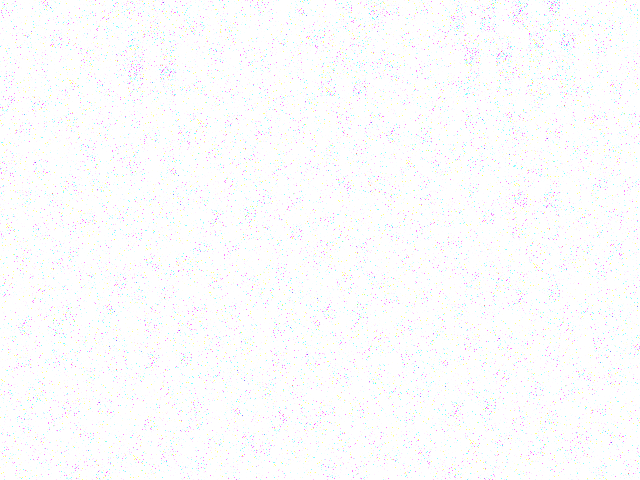

In [246]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True)
ax = ax.flatten()
ax[0].plot(res[:,2], "x--")
ax[1].plot(res2[:,2], "x--")
ax[2].plot(res3.y.T[:,2], "x--")
ax[0].plot(res[:,3], "x--")
ax[1].plot(res2[:,3], "x--")
ax[2].plot(res3.y.T[:,3], "x--")

# An orbit

<IPython.core.display.Javascript object>


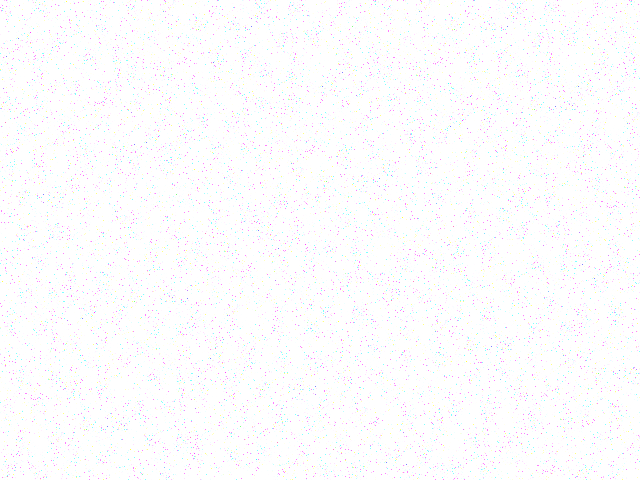

In [336]:
ax, res, res2, res3 = test([1,0,0,1], [np.linspace(0,5,n) for n in (5,11, 25, 101)], [central_factory(2)])

# force balance

<IPython.core.display.Javascript object>


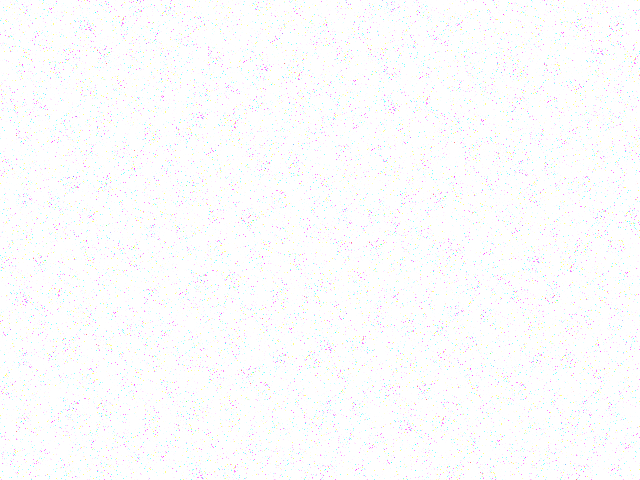

In [204]:
# Small drift when the forces don't add up absolutely perfectly
forces = [const_force_factory([1,0]), const_force_factory([np.cos(np.pi*2/3), np.sin(np.pi*2/3)]), const_force_factory([np.cos(np.pi*2/3), -np.sin(np.pi*2/3)])]
ax, res, res2, res3 = test([1,2,0,0], [np.linspace(0,10,n) for n in (5,10,25,1000)], forces)

# Drag

<IPython.core.display.Javascript object>


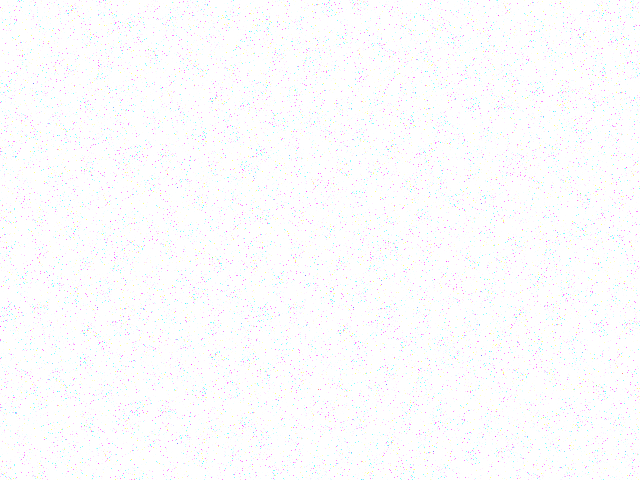

In [402]:
# Small drift when the forces don't add up absolutely perfectly
forces = [drag_factory(1), const_force_factory((0., -9.81))]
ax, res, res2, res3 = test([0,0,1.5,10], [np.linspace(0,2,n) for n in (5,10,25,10000)], forces)
tspace = np.linspace(0,2,100)
for axis in ax:
    axis.plot(1.5*(1-np.exp(-tspace)), (10+9.81)*(1-np.exp(-tspace))-9.81*tspace, "-", label="exact")

# Simple Harmonic Oscillator

## Normal

<IPython.core.display.Javascript object>


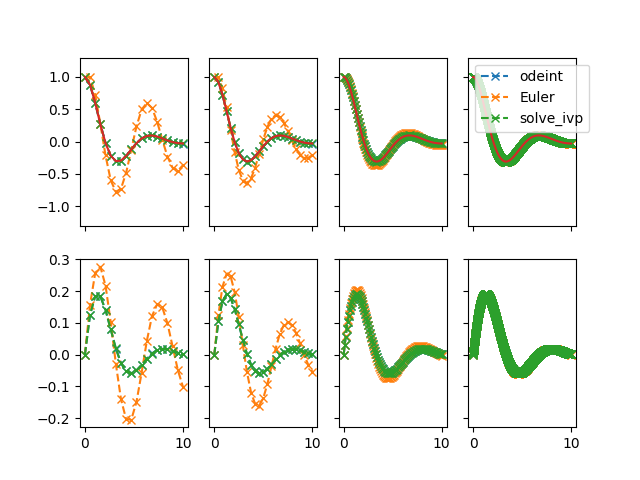

(-1.3, 1.3)

In [17]:
init = np.array([1,0,0,0.3])
times = [np.linspace(0,10,n) for n in (20,25,100,2000)]
c = 0.7
forces = [central_factory(1), drag_factory(c)]

fig, ax = plt.subplots(2,4, sharex=True, sharey="row")
for i in range(4):
    res = odeint(derivatives, init, times[i], args=(forces, 1), tfirst=True)
    res2 = euler(derivatives, init, times[i], args=(forces, 1))
    res3 = solve_ivp(derivatives, (times[i][0], times[i][-1]), init, args=(forces, 1), t_eval=times[i])
    ax[0][i].plot(times[i], res[:,0], "x--", label="odeint")
    ax[1][i].plot(times[i], res[:,1], "x--", label="odeint")
    ax[0][i].plot(times[i], res2[:,0], "x--", label="Euler")
    ax[1][i].plot(times[i], res2[:,1], "x--", label="Euler")
    ax[0][i].plot(times[i], res3.y.T[:,0], "x--", label="solve_ivp")
    ax[1][i].plot(times[i], res3.y.T[:,1], "x--", label="solve_ivp")
    ax[0,i].plot(times[i], np.exp(-c/2*times[i]) * (np.cos(np.sqrt(1-c**2/4)*times[i]) + c/2/np.sqrt(1-c**2/4)*np.sin(np.sqrt(1-c**2/4)*times[i])))
ax[0,-1].legend()
ax[0,0].set_ylim(-1.3,1.3)

<IPython.core.display.Javascript object>


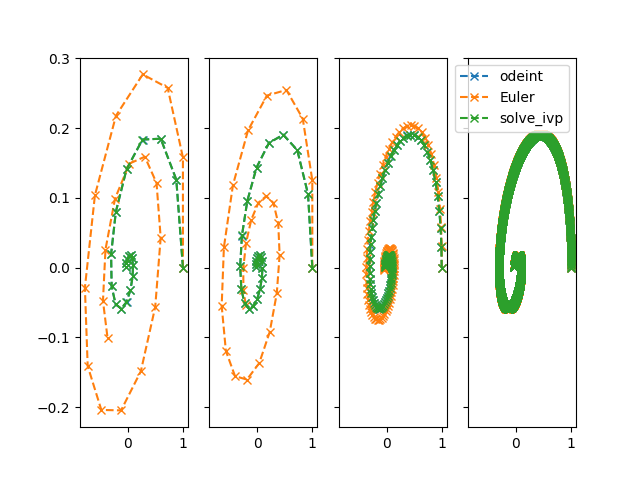

In [18]:
ax, res, res2, res3 = test(init, times, forces)

# How many function calls?

In [184]:
forces = [const_force_factory([0,-9.81])]

In [188]:
cProfile.run("odeint(derivatives, [0,0,1,5], np.linspace(0,1,100), args=(forces, 1), tfirst=True)")

         238 function calls (235 primitive calls) in 0.001 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(any)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(diff)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(linspace)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(ndim)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(result_type)
       12    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(sum)
       12    0.000    0.000    0.000    0.000 <ipython-input-103-ca935724f712>:2(constant_force)
       12    0.000    0.000    0.001    0.000 <ipython-input-150-051b5c2045fa>:1(derivatives)
       12    0.000    0.000    0.000    0.000 <ipython-input-150-051b5c2045fa>:3(<listcomp>)
        1    0.000    0.000

In [189]:
cProfile.run("euler(derivatives, [0,0,1,5], np.linspace(0,1,100), args=(forces, 1))")

         1525 function calls (1522 primitive calls) in 0.005 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(any)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(linspace)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(ndim)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(result_type)
       99    0.000    0.000    0.002    0.000 <__array_function__ internals>:2(sum)
       99    0.000    0.000    0.000    0.000 <ipython-input-103-ca935724f712>:2(constant_force)
        1    0.001    0.001    0.004    0.004 <ipython-input-107-c1a6a8cc3c32>:1(euler)
       99    0.001    0.000    0.003    0.000 <ipython-input-150-051b5c2045fa>:1(derivatives)
       99    0.000    0.000    0.000    0.000 <ipython-input-150-051b5c2045fa>:3(<listcomp>)
        1    0.000    

In [193]:
cProfile.run("solve_ivp(derivatives, (0,1), [0,0,1,5], args=(forces, 1), t_eval=np.linspace(0,1,100))")

         1237 function calls (1222 primitive calls) in 0.005 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        5    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(any)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(atleast_1d)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(concatenate)
        4    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(cumprod)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(diff)
       47    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(dot)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(hstack)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(linspace)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(ndim)
        8    0.000    0.000    0.000    0.0